# Reduce maintenance cost through predictive techniques

<p>
    Company (3D Technologies) has a fleet of devices transmitting daily aggregated telemetry attributes.
    <br>
    Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

<p>
    You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
    <br>
    When building this model, be sure to minimize false positives and false negatives. 

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import lifelines as ll
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.utils import datetimes_to_durations

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.automl import H2OAutoML

import tsfresh
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

In [2]:
# Some configuration here and there
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
# Load the data (Thousand thanks to whoever implemented the URL parameter in Pandas... :)
url_raw_data = 'http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv'
raw_data = pd.read_csv(url_raw_data)

## (Some) exploratory analysis

<p>
    Since we do not have any contextual information on what the data really represents in a detailed manner (i.e., the so-called attributes are just numbers representing something for which we do not have any information) we will look at the data in a loosely manner to figure out some of the following questions given the supplied information about the problem:
    <ul>
        <li> Is the data representing some viable time series for the devices?
        <li> Is there some data correlating each other? (i.e., are there attributes depending on each other?)
        <li> Could we infer some categorical data from the attributes (i.e., is the range of values for some attribute limited enough to assume some sort of encoding?)
        <li> How balanced (or imbalaced) is the data? (i.e., how many devices are failing vs. those not failing?)

In [4]:
# Let's take a quick look at the data
raw_data.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [5]:
# And more precisely to some standard metrics on each column 
raw_data.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


<p>
    It seems that <code>attribute7</code> and <code>attribute8</code> are the same (i.e., to be checked in a bit).
    <br>
    Otherwise all other attributes seem numerical. Perhaps <code>attribute5</code> could point to some encoding of a categorical value as the range of values (i.e., min and max) is rather small compared to the range of values in the other attributes.
    <br>
    And we do not seem to miss data (e.g., no NA values in the data frame).

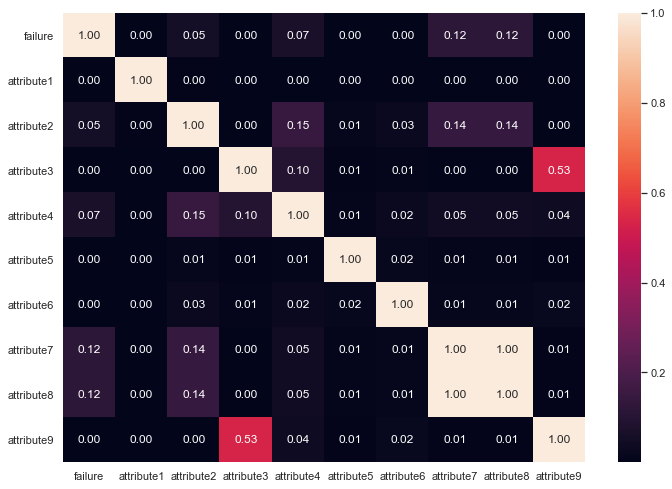

In [6]:
# So let's check for correlations
sns.heatmap(data=raw_data[raw_data.columns].corr().abs(), annot=True, fmt='.2f')

<p>
    We can confirm the perfect correlation between <code>attribute7</code> and <code>attribute8</code>, so one of them will be removed when running algorithms.
    <br>
    Otherwise, the other attributes do not seem to be correlated. While attributes <code>attribute3</code> and <code>attribute9</code> have some correlation indication, I think that the coefficient is not sufficiently high enough to investigate further and ellaborate more.

0    124388
1       106
Name: failure, dtype: int64


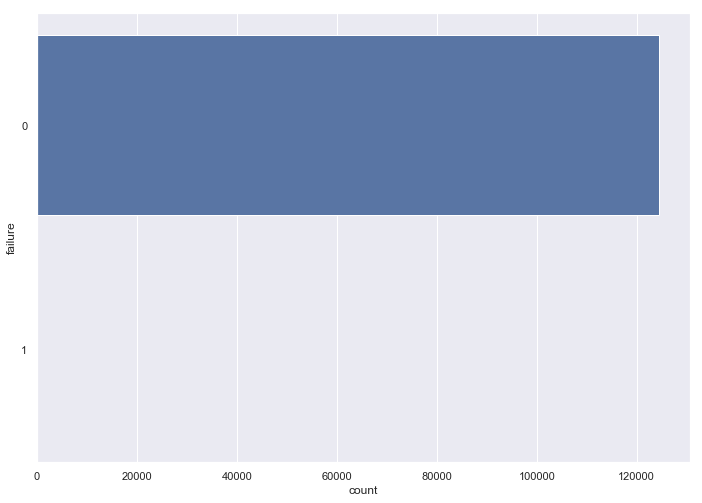

In [7]:
# Let's check whether we have an imbalaced dataset or not...
sns.countplot(y='failure', data=raw_data)
print(raw_data['failure'].value_counts())

0    1063
1     106
Name: failure, dtype: int64


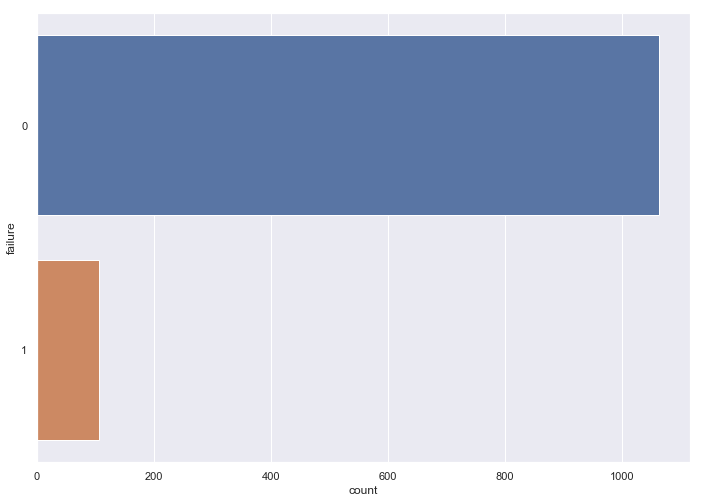

In [8]:
# Looks like the dataset is imbalanced.
# For safety we check again aggregating by device and keeping the latest event (after that the device is removed anyways)
raw_data_by_device = raw_data.groupby('device').agg('max')
sns.countplot(y='failure', data=raw_data_by_device)
print(raw_data_by_device['failure'].value_counts())

<p>
    We do clearly have an imbalanced data set, whether we look at each event independently or on a device aggregated manner up to the last event observed.
    <br>
    In the case of individual events the ratio is almost 1200% while in the case of the aggregation per device when looking at the latest event observed it is of 10 times difference.

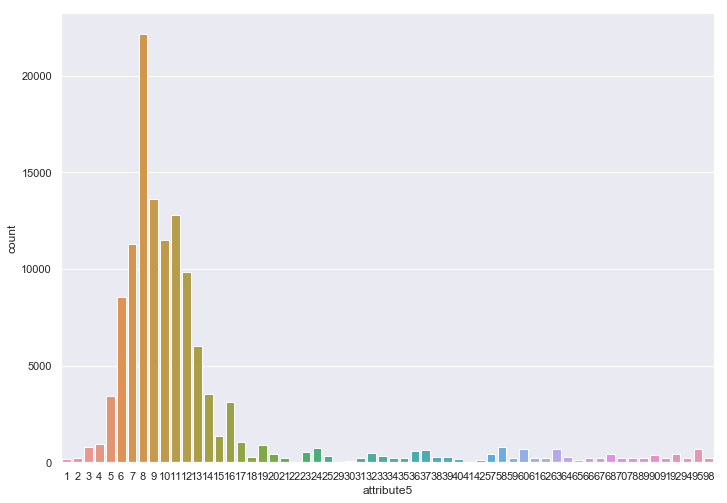

In [9]:
#Let's check how many uniques values attribute5 could have for a possiblity of being a categorical feature
sns.countplot(x='attribute5', data=raw_data)

<p>
    I am inclined to think of this feature could be easily categorical given its distribution.
    <br>
    As it is highly skewed to the left concentrated in few values (between 1 and 20 pretty much), I think that it could possibly either limited to that range (aggregating anything over 20 on that last number) or perhaps binned (being careful not to distort too much when the <code>attribute5</code> value is 8.

/Users/billy/.local/share/virtualenvs/maintenance-cost-reduction-FcMAjIkj/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/billy/.local/share/virtualenvs/maintenance-cost-reduction-FcMAjIkj/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/billy/.local/share/virtualenvs/maintenance-cost-reduction-FcMAjIkj/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A valu

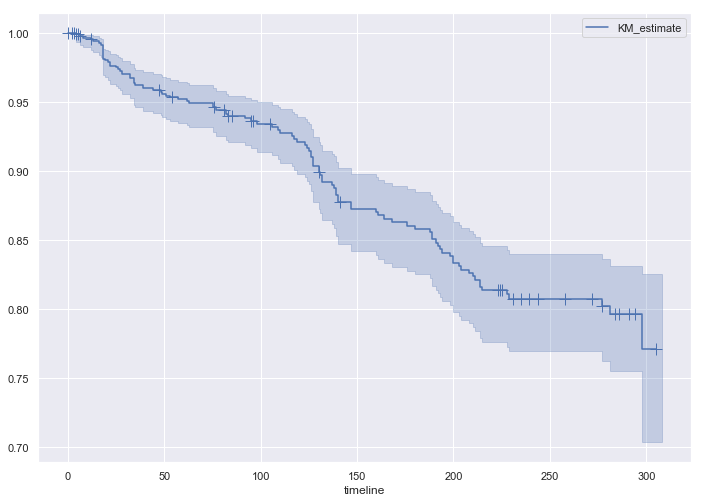

In [10]:
# Let's check how the devices 'die' with some brief survival analysis
# Some (nasty) copying of data...
survival_raw_data = raw_data[['device']]
survival_raw_data['start_date'] = raw_data[['date']]
survival_raw_data['end_date'] = raw_data[['date']]
survival_raw_data['death'] = raw_data[['failure']]
# Prepare and carry out the operations to calculate the duration and observed 'death' event parameters of the estimator
ops = {'start_date':'first',
       'end_date': 'last', 
       'death': 'sum'
      }
survival_data = survival_raw_data.groupby('device', as_index=False).agg(ops)


# T = pd.to_datetime(survival_data['end_date']) - pd.to_datetime(survival_data['start_date'])
T, _ = datetimes_to_durations(pd.to_datetime(survival_data['start_date']),
                              pd.to_datetime(survival_data['end_date']))
E = survival_data['death'].astype('bool').values

# Estimate and plot
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.plot(show_censors=True)

<p>
    From the above plot we see that the probability of survival is high even after the longest period. We were expecting this anyways from the check for imbalance data as about 10% of the devices stopped functioning

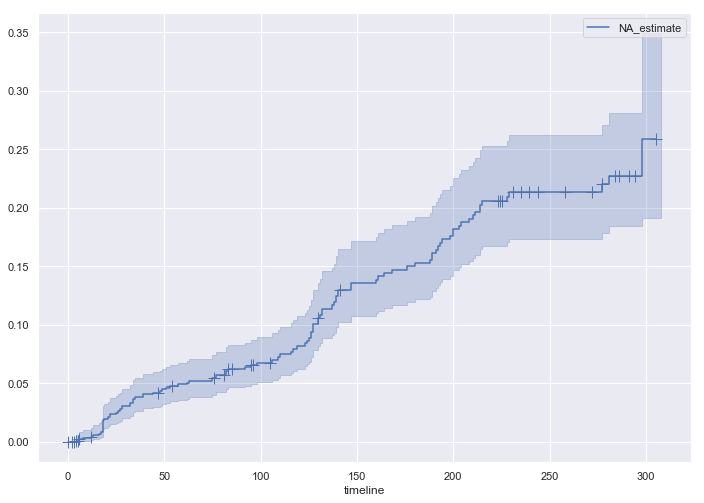

In [11]:
# We can also estimate the hazard rates using the Nelson-Aalen estimator
# The library provides the cumulative hazard function though
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)
# print(naf.cumulative_hazard_.head())
naf.plot(show_censors=True)

## (Some) machine learning

<p>
    In order to do some prediction we are going to leverage on machine learning algorithms. I will try a couple of them and possibly explore the AutoML feature of the framework H2O (if I have time).
    <br>
    There is a catch with this dataset though because it is not only imbalanced but also some sort of time series. We could potentially address both 'issues' with some neuronal network representation (e.g., RNNs) but the amount of data is rather small and maybe we are simply killing a fly with a tank.
    <br>
    Therefore, a typical solution to the imbalance problem is to even the classes to classify by resampling (e.g., 50% for <code>failure</code>'s value 0 and another 50% for <code>failure</code>'s value 1) at the cost of losing information (if downsampling) or duplicating entries and possibly overfitting (if upsampling).
    <br>
    Another typical solution to the time series representation when one does not want to actually model them as such is aggregation of features to generate new features that represent the time series per item (or device in our case). There are plenty of metrics (e.g., average, deviation, etc...) and also some tools to do this process automatically.

In [12]:
# Since the solutions will require some supervised algorithm we split the input in 
# what will be the precursor of the features and also the expected outcome
# Note that y will be the final state of every device at the end of each device's time series
x = raw_data.sort_values('date').groupby('device', as_index=False).apply(lambda x: x.iloc[:-1])
y = raw_data.sort_values('date').groupby('device').tail(1)

# Drop the outcome and the duplicate attribute from the precursor of the features
x.drop(['failure','attribute8'], axis=1, inplace=True)
# Prepare the expected outcome for processing
y = y[y.attribute1 != 231813424] # Quick fix for a weird character in a device id causing issues
y = y.set_index('device')
y = y['failure']

In [13]:
# Thanks to the package tsfresh we extract characteristics from each time series (i.e., each device)
# The used method does wonders: performs the feature extraction
# x_filtered = extract_relevant_features(x, y, column_id='device', column_sort='date')
x_ft = extract_features(x, column_id='device', column_sort='date')

Feature Extraction: 20it [07:10, 18.83s/it]                        


In [14]:
# After the feature extraction we have to do some cleanup (e.g., NAs) and remove irrelevant features
# The extraction, imputing and filtering could happen at once as well, see below,
# x_ft_filtered = extract_relevant_features(x, y, column_id='device', column_sort='date')
impute(x_ft)
x_ft_filtered = select_features(x_ft, y)

 'attribute3__friedrich_coefficients__m_3__r_30__coeff_1'
 'attribute3__friedrich_coefficients__m_3__r_30__coeff_2'
 'attribute3__friedrich_coefficients__m_3__r_30__coeff_3'
 'attribute3__max_langevin_fixed_point__m_3__r_30'
 'attribute5__friedrich_coefficients__m_3__r_30__coeff_0'
 'attribute5__friedrich_coefficients__m_3__r_30__coeff_1'
 'attribute5__friedrich_coefficients__m_3__r_30__coeff_2'
 'attribute5__friedrich_coefficients__m_3__r_30__coeff_3'
 'attribute5__max_langevin_fixed_point__m_3__r_30'
 'attribute7__friedrich_coefficients__m_3__r_30__coeff_0'
 'attribute7__friedrich_coefficients__m_3__r_30__coeff_1'
 'attribute7__friedrich_coefficients__m_3__r_30__coeff_2'
 'attribute7__friedrich_coefficients__m_3__r_30__coeff_3'
 'attribute7__max_langevin_fixed_point__m_3__r_30'
 'attribute9__friedrich_coefficients__m_3__r_30__coeff_0'
 'attribute9__friedrich_coefficients__m_3__r_30__coeff_1'
 'attribute9__friedrich_coefficients__m_3__r_30__coeff_2'
 'attribute9__friedrich_coefficient

In [15]:
# We now split the data into training and test
x_trn, x_tst, y_trn, y_tst = train_test_split(x_ft_filtered, y, test_size=.3)

In [16]:
# And we finally run something, a decision tree classifier
DTCl = DecisionTreeClassifier()
DTCl.fit(x_trn, y_trn)
print(classification_report(y_tst, DTCl.predict(x_tst)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       321
           1       0.15      0.23      0.18        30

   micro avg       0.82      0.82      0.82       351
   macro avg       0.53      0.55      0.54       351
weighted avg       0.86      0.82      0.84       351



<p>
    The performance is not that great to identify failing devices because of the imbalanced dataset.
    <br>
    I ran this on purpose to precisely show this, and how one solution (while not optimal though) is resampling.

In [17]:
# In order to do the resampling I have to concatenate both input features and the target variable
r = pd.concat([x_ft_filtered, y], axis=1, sort=False)
# And check which type of the target variable class should be downsampled...
r.groupby('failure').count()

,attribute7__ar_coefficient__k_10__coeff_0,"attribute4__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","attribute4__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.6",attribute7__spkt_welch_density__coeff_5,"attribute4__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.6","attribute4__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","attribute4__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.4","attribute4__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.4",attribute7__spkt_welch_density__coeff_2,"attribute4__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",...,"attribute6__fft_coefficient__coeff_64__attr_""real""",attribute9__ratio_beyond_r_sigma__r_2.5,"attribute7__fft_coefficient__coeff_95__attr_""abs""","attribute7__fft_coefficient__coeff_42__attr_""angle""","attribute9__fft_coefficient__coeff_4__attr_""imag""","attribute2__fft_coefficient__coeff_87__attr_""angle""","attribute4__fft_coefficient__coeff_21__attr_""real""","attribute1__agg_autocorrelation__f_agg_""median""","attribute7__fft_coefficient__coeff_98__attr_""abs""",attribute2__index_mass_quantile__q_0.1
failure,,,,,,,,,,,,,,,,,,,,,
0,1067,1067,1067,1067,1067,1067,1067,1067,1067,1067,...,1067,1067,1067,1067,1067,1067,1067,1067,1067,1067
1,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101


In [18]:
# So we have to take as many devices that don't fail as those that do (i.e., 101)
r_0 = r[r['failure'] == 0].sample(n=101)
r_1 = r[r['failure'] == 1]
# Then we merge both subsets and get back again the features and the expected outcome for a train/test split
r_rbl = pd.concat([r_0, r_1])
yy = r_rbl['failure']
xx = r_rbl.drop(columns=['failure'])

In [19]:
xx_trn, xx_tst, yy_trn, yy_tst = train_test_split(xx, yy, test_size=.3)

In [20]:
# Rebalance the test set so that it has the same distribution as the original dataset
tst_merged = pd.concat([xx_tst, yy_tst], axis=1, sort=False)

tst_count_1 = tst_merged.groupby('failure').size().reset_index(name='count')['count'][1]
r_count_0 = r.groupby('failure').size().reset_index(name='count')['count'][0]
r_count_1 = r.groupby('failure').size().reset_index(name='count')['count'][1]
tst_count_0 = (tst_count_1 * r_count_0) / r_count_1

In [21]:
# And the actual rebalance (which is actually unbalancing)
r_minus_tst_merged = r[~r.index.isin(tst_merged.index)]
tst_unbalanced = pd.concat([r_minus_tst_merged[r_minus_tst_merged['failure'] == 0].sample(n=tst_count_0 - tst_merged.groupby('failure').size().reset_index(name='count')['count'][0]),
                           tst_merged])
yy_tst = tst_unbalanced['failure']
xx_tst = tst_unbalanced.drop(['failure'], axis=1, inplace=False)

In [22]:
# We run again the decision tree classifier
DTCl = DecisionTreeClassifier()
DTCl.fit(xx_trn, yy_trn)
print(classification_report(yy_tst, DTCl.predict(xx_tst)))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       359
           1       0.31      0.71      0.43        34

   micro avg       0.84      0.84      0.84       393
   macro avg       0.64      0.78      0.67       393
weighted avg       0.91      0.84      0.87       393



In [23]:
# We also try a logistic regression classifier with cross-validation
LRCl = LogisticRegressionCV(max_iter=5000)
LRCl.fit(xx_trn, yy_trn)
print(classification_report(yy_tst, LRCl.predict(xx_tst)))

/Users/billy/.local/share/virtualenvs/maintenance-cost-reduction-FcMAjIkj/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       0.92      0.65      0.77       359
           1       0.10      0.41      0.16        34

   micro avg       0.63      0.63      0.63       393
   macro avg       0.51      0.53      0.46       393
weighted avg       0.85      0.63      0.71       393



In [24]:
# And a random forest classifier
RFCl = RandomForestClassifier(n_estimators=10)
RFCl.fit(xx_trn, yy_trn)
print(classification_report(yy_tst, RFCl.predict(xx_tst)))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       359
           1       0.49      0.76      0.60        34

   micro avg       0.91      0.91      0.91       393
   macro avg       0.73      0.84      0.77       393
weighted avg       0.93      0.91      0.92       393



In [25]:
# Or some gradient boosting too...
GBCl = GradientBoostingClassifier()
GBCl.fit(xx_trn, yy_trn)
print(classification_report(yy_tst, GBCl.predict(xx_tst)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       359
           1       0.37      0.68      0.48        34

   micro avg       0.87      0.87      0.87       393
   macro avg       0.67      0.78      0.70       393
weighted avg       0.92      0.87      0.89       393



<p>
    From the above algorithms and after the downsampling the results are much better which seems to be in line with the majority class of non-failing devices influencing the dataset if taken all at once.
    <br>
    We are certainly losing information with the sampling (and I haven't done any cross-validation) but the numbers are meaningful enough to hint at the idea that the sampling must be done while also the aggregation of the time series by generating new features is a good idea in lieu of the amount of data available. 

### Some H2O AutoML

In [26]:
# Initialise the H2O 'cluster' (Java is needed, otherwise this will fail)
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16; OpenJDK Runtime Environment 18.9 (build 11.0.1+13); OpenJDK 64-Bit Server VM 18.9 (build 11.0.1+13, mixed mode)
  Starting server from /Users/billy/.local/share/virtualenvs/maintenance-cost-reduction-FcMAjIkj/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/q6/7jrs78gj51bccjx77s854vl00000gn/T/tmpsXfcea
  JVM stdout: /var/folders/q6/7jrs78gj51bccjx77s854vl00000gn/T/tmpsXfcea/h2o_billy_started_from_python.out
  JVM stderr: /var/folders/q6/7jrs78gj51bccjx77s854vl00000gn/T/tmpsXfcea/h2o_billy_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Stockholm
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,26 days
H2O cluster name:,H2O_from_python_billy_tbquro
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [27]:
# Load the data (unbalanced, H2O has an option to take care of that) and get some basic information
r_h2o = h2o.H2OFrame(r)
r_h2o.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:1168
Cols:2217




attribute7__ar_coefficient__k_10__coeff_0 attribute4__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6 attribute4__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6 attribute7__spkt_welch_density__coeff_5 attribute4__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6 attribute4__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6 attribute4__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4 attribute4__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4 attribute7__spkt_welch_density__coeff_2 attribute4__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.2 attribute4__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2 attribute4__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope" attribute4__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2 attribute4__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2 attribute4__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue" attribute7__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"slope" attribute7__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"rvalue" attribute4__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4 attribute4__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4 attribute7__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"slope" attribute7__spkt_welch_density__coeff_8 attribute7__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue" attribute7__fft_coefficient__coeff_2__attr_"angle" attribute7__linear_trend__attr_"slope" attribute4__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"slope" attribute7__maximum attribute7__first_location_of_maximum attribute7__linear_trend__attr_"rvalue" attribute7__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"stderr" attribute7__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"stderr" attribute7__linear_trend__attr_"stderr" attribute7__mean_abs_change attribute7__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0 attribute7__abs_energy attribute7__sample_entropy attribute4__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"rvalue" attribute4__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"stderr" attribute7__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 attribute7__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0 attribute4__first_location_of_maximum attribute7__sum_values attribute7__fft_coefficient__coeff_0__attr_"real" attribute7__fft_coefficient__coeff_0__attr_"abs" attribute7__absolute_sum_of_changes attribute7__cid_ce__normalize_False attribute7__mean attribute7__standard_deviation attribute7__variance attribute4__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope" attribute7__approximate_entropy__m_2__r_0.7 attribute4__mean_change attribute4__mean_abs_change attribute4__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0 attribute4__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0 attribute7__approximate_entropy__m_2__r_0.3 attribute7__approximate_entropy__m_2__r_0.5 attribute4__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0 attribute4__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 attribute7__approximate_entropy__m_2__r_0.1 attribute4__absolute_sum_of_changes attribute4__cid_ce__normalize_False attribute7__approximate_entropy__m_2__r_0.9 attribute7__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue" attribute7__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope" attribute7__binned_entropy__max_bins_10 attribute7__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue" attribute7__ratio_beyond_r_sigma__r_0.5 attribute4__linear_trend__attr_"stderr" attribute7__ratio_beyond_r_sigma__r_1 attribute7__agg_autocorrelation__f_agg_"var" attribute4__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue" attribute7__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope" attribute7__cid_ce__normalize_True attribute4__standard_deviation attribute4__variance attribute7__change_quantiles__f_agg_"mean"__isabs_Tru

In [28]:
# Configure the predictors (features) and the response (our target)
predictors = list(set(r_h2o.col_names))
response = 'failure'
# Remove the target and the duplicate mentioned above from the features
predictors.remove(response)

In [29]:
# As we are on a classification problem... the response should be of that categorical kind...
r_h2o[response] = r_h2o[response].asfactor()
# And we also do some train/test/validation split
trn_h2o, tst_h2o, vld_h2o = r_h2o.split_frame(ratios=[.7, .15])

In [30]:
# Some gradient boosting via H2O framework
gbm_h2o = H2OGradientBoostingEstimator(ntrees = 150,
                                       seed = 1234,
                                       balance_classes=True)
gbm_h2o.train(x = predictors,
              y = response,
              training_frame = trn_h2o,
              validation_frame = vld_h2o)
gbm_h2o

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1545164424090_1


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 3.02423373006e-07
RMSE: 0.000549930334684
LogLoss: 0.000316991912231
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.986338797814
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.997459421426: 


,0,1,Error,Rate
0,733.0,0.0,0.0,(0.0/733.0)
1,0.0,732.0,0.0,(0.0/732.0)
Total,733.0,732.0,0.0,(0.0/1465.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.9974594,1.0,68.0
max f2,0.9974594,1.0,68.0
max f0point5,0.9974594,1.0,68.0
max accuracy,0.9974594,1.0,68.0
max precision,0.9999017,1.0,0.0
max recall,0.9974594,1.0,68.0
max specificity,0.9999017,1.0,0.0
max absolute_mcc,0.9974594,1.0,68.0
max min_per_class_accuracy,0.9974594,1.0,68.0
max mean_per_class_accuracy,0.9974594,1.0,68.0


Gains/Lift Table: Avg response rate: 49.97 %, avg score: 49.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0143345,0.9998541,2.0013661,2.0013661,1.0,0.9998767,1.0,0.9998767,0.0286885,0.0286885,100.1366120,100.1366120
,2,0.0211604,0.9998335,2.0013661,2.0013661,1.0,0.9998335,1.0,0.9998628,0.0136612,0.0423497,100.1366120,100.1366120
,3,0.0354949,0.9997884,2.0013661,2.0013661,1.0,0.9997924,1.0,0.9998344,0.0286885,0.0710383,100.1366120,100.1366120
,4,0.0430034,0.9997863,2.0013661,2.0013661,1.0,0.9997863,1.0,0.9998260,0.0150273,0.0860656,100.1366120,100.1366120
,5,0.0505119,0.9997773,2.0013661,2.0013661,1.0,0.9997779,1.0,0.9998188,0.0150273,0.1010929,100.1366120,100.1366120
,6,0.1017065,0.9997223,2.0013661,2.0013661,1.0,0.9997453,1.0,0.9997818,0.1024590,0.2035519,100.1366120,100.1366120
,7,0.1535836,0.9996812,2.0013661,2.0013661,1.0,0.9996936,1.0,0.9997520,0.1038251,0.3073770,100.1366120,100.1366120
,8,0.2047782,0.9996012,2.0013661,2.0013661,1.0,0.9996416,1.0,0.9997244,0.1024590,0.4098361,100.1366120,100.1366120
,9,0.3058020,0.9993718,2.0013661,2.0013661,1.0,0.9994964,1.0,0.9996491,0.2021858,0.6120219,100.1366120,100.1366120
,10,0.4,0.9990842,2.0013661,2.0013661,1.0,0.9992486,1.0,0.9995548,0.1885246,0.8005464,100.1366120,100.1366120




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.0494599953303
RMSE: 0.222396032632
LogLoss: 0.306552441952
Mean Per-Class Error: 0.0858585858586
AUC: 0.97138047138
pr_auc: 0.766683518747
Gini: 0.942760942761
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00521575221666: 


,0,1,Error,Rate
0,162.0,3.0,0.0182,(3.0/165.0)
1,4.0,14.0,0.2222,(4.0/18.0)
Total,166.0,17.0,0.0383,(7.0/183.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0052158,0.8,16.0
max f2,0.0002875,0.8163265,25.0
max f0point5,0.0258799,0.8333333,14.0
max accuracy,0.0258799,0.9617486,14.0
max precision,0.9997472,1.0,0.0
max recall,0.0000122,1.0,46.0
max specificity,0.9997472,1.0,0.0
max absolute_mcc,0.0052158,0.7792600,16.0
max min_per_class_accuracy,0.0002875,0.8888889,25.0
max mean_per_class_accuracy,0.0002875,0.9141414,25.0


Gains/Lift Table: Avg response rate:  9.84 %, avg score:  5.73 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0109290,0.9988852,10.1666667,10.1666667,1.0,0.9996517,1.0,0.9996517,0.1111111,0.1111111,916.6666667,916.6666667
,2,0.0218579,0.9924724,10.1666667,10.1666667,1.0,0.9984266,1.0,0.9990392,0.1111111,0.2222222,916.6666667,916.6666667
,3,0.0327869,0.9565187,5.0833333,8.4722222,0.5,0.9773830,0.8333333,0.9918204,0.0555556,0.2777778,408.3333333,747.2222222
,4,0.0437158,0.8998900,10.1666667,8.8958333,1.0,0.9432172,0.875,0.9796696,0.1111111,0.3888889,916.6666667,789.5833333
,5,0.0546448,0.7014051,10.1666667,9.15,1.0,0.7642606,0.9,0.9365878,0.1111111,0.5,916.6666667,815.0
,6,0.1038251,0.0009165,5.6481481,7.4912281,0.5555556,0.1241493,0.7368421,0.5517485,0.2777778,0.7777778,464.8148148,649.1228070
,7,0.1530055,0.0001505,2.2592593,5.8095238,0.2222222,0.0004052,0.5714286,0.3745310,0.1111111,0.8888889,125.9259259,480.9523810
,8,0.2021858,0.0000393,0.0,4.3963964,0.0,0.0000782,0.4324324,0.2834479,0.0,0.8888889,-100.0,339.6396396
,9,0.3005464,0.0000086,1.1296296,3.3272727,0.1111111,0.0000166,0.3272727,0.1906886,0.1111111,1.0,12.9629630,232.7272727
,10,0.3989071,0.0000049,0.0,2.5068493,0.0,0.0000069,0.2465753,0.1436712,0.0,1.0,-100.0,150.6849315



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2018-12-18 21:20:35,0.018 sec,0.0,0.6489103,1.2706760,0.5,0.0,1.0,0.5003413,0.2980566,0.3223930,0.5,0.0,1.0,0.9016393
,2018-12-18 21:20:38,2.161 sec,1.0,0.6373720,1.1823169,0.9878261,0.7265306,2.0013661,0.0361775,0.2933124,0.3048398,0.8052189,0.3981843,3.3888889,0.0710383
,2018-12-18 21:20:38,2.689 sec,2.0,0.6254326,1.1028012,0.9920772,0.7744863,2.0013661,0.0156997,0.2905463,0.2952807,0.8001684,0.3847845,3.3888889,0.0819672
,2018-12-18 21:20:39,3.059 sec,3.0,0.6130617,1.0309110,0.9962995,0.8799780,2.0013661,0.0102389,0.2870369,0.2842903,0.8020202,0.4803633,5.0833333,0.0546448
,2018-12-18 21:20:39,3.294 sec,4.0,0.5997957,0.9633850,0.9992582,0.9841595,2.0013661,0.0040956,0.2853227,0.2793590,0.8200337,0.5876382,10.1666667,0.0710383
,2018-12-18 21:20:39,3.574 sec,5.0,0.5865808,0.9036483,0.9991259,0.9689554,2.0013661,0.0040956,0.2824055,0.2727315,0.8222222,0.5970556,10.1666667,0.0655738
,2018-12-18 21:20:39,3.906 sec,6.0,0.5729612,0.8488878,0.9990681,0.9839262,2.0013661,0.0075085,0.2799602,0.2683984,0.8212121,0.5908707,10.1666667,0.0710383
,2018-12-18 21:20:40,4.073 sec,7.0,0.5588724,0.7974103,0.9994306,0.9857025,2.0013661,0.0040956,0.2771984,0.2629761,0.8279461,0.6117787,10.1666667,0.0601093
,2018-12-18 21:20:40,4.238 sec,8.0,0.5445546,0.7499184,0.9994660,0.9857444,2.0013661,0.0034130,0.2746849,0.2588384,0.8297980,0.6143667,10.1666667,0.0601093
,2018-12-18 21:20:40,4.403 sec,9.0,0.5295169,0.7044420,0.9996757,0.9859899,2.0013661,0.0013652,0.2723081,0.2566409,0.8203704,0.6052154,10.1666667,0.0601093


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"attribute6__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""rvalue""",346.8120728,1.0,0.1779169
"attribute6__fft_coefficient__coeff_58__attr_""angle""",154.4348907,0.4452985,0.0792261
"attribute6__fft_coefficient__coeff_36__attr_""angle""",122.8134460,0.3541210,0.0630041
attribute7__mean,102.7857437,0.2963730,0.0527298
"attribute6__fft_coefficient__coeff_3__attr_""abs""",99.4598465,0.2867831,0.0510236
---,---,---,---
"attribute7__fft_coefficient__coeff_42__attr_""angle""",0.0,0.0,0.0
"attribute9__fft_coefficient__coeff_4__attr_""imag""",0.0,0.0,0.0
"attribute2__fft_coefficient__coeff_87__attr_""angle""",0.0,0.0,0.0
"attribute4__fft_coefficient__coeff_21__attr_""real""",0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [31]:
# And the corresponding prediction since we generated some test data from the split of data
predict = gbm_h2o.predict(tst_h2o)
predict.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.999999,1.28314e-06
0,0.999999,1.18499e-06
0,0.999998,1.89281e-06
0,0.999999,1.18499e-06
0,0.999998,2.18532e-06
0,0.999999,1.12314e-06
0,0.999982,1.77649e-05
0,0.9976,0.00239971
0,0.999997,2.87992e-06
0,0.999997,2.53951e-06


#### And here we go with the AutoML feature of H2O

In [32]:
# Run AutoML for 25 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=25,
                seed=1234,
                balance_classes=True)
aml.train(x=predictors,
          y=response,
          training_frame = trn_h2o,
          validation_frame = vld_h2o)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [33]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_5_AutoML_20181218_212100,0.960783,0.163365,0.140924,0.222229,0.0493856
GBM_3_AutoML_20181218_212100,0.959952,0.187965,0.130949,0.225127,0.0506822
GBM_4_AutoML_20181218_212100,0.959794,0.190521,0.106738,0.225358,0.0507864
GBM_2_AutoML_20181218_212100,0.959646,0.192162,0.0942919,0.226042,0.0510951
XGBoost_1_AutoML_20181218_212100,0.957075,0.133143,0.135724,0.19918,0.0396725
XGBoost_2_AutoML_20181218_212100,0.956611,0.141367,0.140242,0.20199,0.0407998
GBM_grid_1_AutoML_20181218_212100_model_3,0.953783,0.246773,0.157888,0.267866,0.0717522
XGBoost_grid_1_AutoML_20181218_212100_model_2,0.951776,0.137202,0.105631,0.199713,0.0398852
XGBoost_grid_1_AutoML_20181218_212100_model_1,0.94715,0.173082,0.109299,0.219984,0.048393
GBM_1_AutoML_20181218_212100,0.946468,0.208788,0.182781,0.22489,0.0505755


In [34]:
# Some information about the leader model
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_20181218_212100


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0974954994607
RMSE: 0.312242693206
LogLoss: 0.295840897565
Mean Per-Class Error: 0.00613915416098
AUC: 0.999757714013
pr_auc: 0.984729076288
Gini: 0.999515428026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.116883792871: 


,0,1,Error,Rate
0,724.0,9.0,0.0123,(9.0/733.0)
1,0.0,732.0,0.0,(0.0/732.0)
Total,724.0,741.0,0.0061,(9.0/1465.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1168838,0.9938900,77.0
max f2,0.1168838,0.9975470,77.0
max f0point5,0.2440715,0.9950386,69.0
max accuracy,0.1168838,0.9938567,77.0
max precision,0.7965337,1.0,0.0
max recall,0.1168838,1.0,77.0
max specificity,0.7965337,1.0,0.0
max absolute_mcc,0.1168838,0.9877880,77.0
max min_per_class_accuracy,0.1168838,0.9877217,77.0
max mean_per_class_accuracy,0.1168838,0.9938608,77.0


Gains/Lift Table: Avg response rate: 49.97 %, avg score: 29.53 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0150171,0.7907835,2.0013661,2.0013661,1.0,0.7936586,1.0,0.7936586,0.0300546,0.0300546,100.1366120,100.1366120
,2,0.0225256,0.7752845,2.0013661,2.0013661,1.0,0.7752845,1.0,0.7875339,0.0150273,0.0450820,100.1366120,100.1366120
,3,0.0368601,0.7594922,2.0013661,2.0013661,1.0,0.7651972,1.0,0.7788474,0.0286885,0.0737705,100.1366120,100.1366120
,4,0.0436860,0.7536055,2.0013661,2.0013661,1.0,0.7536055,1.0,0.7749034,0.0136612,0.0874317,100.1366120,100.1366120
,5,0.0505119,0.7369493,2.0013661,2.0013661,1.0,0.7397702,1.0,0.7701556,0.0136612,0.1010929,100.1366120,100.1366120
,6,0.1010239,0.7115568,2.0013661,2.0013661,1.0,0.7192832,1.0,0.7447194,0.1010929,0.2021858,100.1366120,100.1366120
,7,0.1515358,0.6623621,2.0013661,2.0013661,1.0,0.6848495,1.0,0.7247628,0.1010929,0.3032787,100.1366120,100.1366120
,8,0.2027304,0.6225375,2.0013661,2.0013661,1.0,0.6419233,1.0,0.7038437,0.1024590,0.4057377,100.1366120,100.1366120
,9,0.3064846,0.5599067,2.0013661,2.0013661,1.0,0.5945114,1.0,0.6668314,0.2076503,0.6133880,100.1366120,100.1366120
,10,0.4068259,0.4843011,2.0013661,2.0013661,1.0,0.5170180,1.0,0.6298808,0.2008197,0.8142077,100.1366120,100.1366120




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.0555230455074
RMSE: 0.235633286077
LogLoss: 0.199156697815
Mean Per-Class Error: 0.106060606061
AUC: 0.954208754209
pr_auc: 0.705906249219
Gini: 0.908417508418
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0575100919134: 


,0,1,Error,Rate
0,157.0,8.0,0.0485,(8.0/165.0)
1,4.0,14.0,0.2222,(4.0/18.0)
Total,161.0,22.0,0.0656,(12.0/183.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0575101,0.7,21.0
max f2,0.0334454,0.75,27.0
max f0point5,0.5534207,0.7608696,6.0
max accuracy,0.1758631,0.9453552,11.0
max precision,0.7786932,1.0,0.0
max recall,0.0108535,1.0,51.0
max specificity,0.7786932,1.0,0.0
max absolute_mcc,0.0575101,0.6678147,21.0
max min_per_class_accuracy,0.0334454,0.8333333,27.0
max mean_per_class_accuracy,0.0108535,0.8939394,51.0


Gains/Lift Table: Avg response rate:  9.84 %, avg score:  4.53 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0109290,0.7339130,10.1666667,10.1666667,1.0,0.7613330,1.0,0.7613330,0.1111111,0.1111111,916.6666667,916.6666667
,2,0.0218579,0.7049468,10.1666667,10.1666667,1.0,0.7308359,1.0,0.7460845,0.1111111,0.2222222,916.6666667,916.6666667
,3,0.0327869,0.5712056,10.1666667,10.1666667,1.0,0.6386143,1.0,0.7102611,0.1111111,0.3333333,916.6666667,916.6666667
,4,0.0437158,0.3931286,5.0833333,8.8958333,0.5,0.4983759,0.875,0.6572898,0.0555556,0.3888889,408.3333333,789.5833333
,5,0.0546448,0.2520231,5.0833333,8.1333333,0.5,0.2599325,0.8,0.5778183,0.0555556,0.4444444,408.3333333,713.3333333
,6,0.1038251,0.0764216,4.5185185,6.4210526,0.4444444,0.1211160,0.6315789,0.3614857,0.2222222,0.6666667,351.8518519,542.1052632
,7,0.1530055,0.0333288,3.3888889,5.4464286,0.3333333,0.0496918,0.5357143,0.2612662,0.1666667,0.8333333,238.8888889,444.6428571
,8,0.2021858,0.0223314,0.0,4.1216216,0.0,0.0256644,0.4054054,0.2039577,0.0,0.8333333,-100.0,312.1621622
,9,0.3005464,0.0101373,1.6944444,3.3272727,0.1666667,0.0158049,0.3272727,0.1423804,0.1666667,1.0,69.4444444,232.7272727
,10,0.3989071,0.0065180,0.0,2.5068493,0.0,0.0076871,0.2465753,0.1091683,0.0,1.0,-100.0,150.6849315




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.0493856408224
RMSE: 0.222228802864
LogLoss: 0.163365373176
Mean Per-Class Error: 0.0796310575953
AUC: 0.960782569152
pr_auc: 0.753669599796
Gini: 0.921565138304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0822688321738: 


,0,1,Error,Rate
0,707.0,26.0,0.0355,(26.0/733.0)
1,17.0,52.0,0.2464,(17.0/69.0)
Total,724.0,78.0,0.0536,(43.0/802.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0822688,0.7074830,77.0
max f2,0.0390219,0.8035714,114.0
max f0point5,0.2579499,0.7551020,43.0
max accuracy,0.1610231,0.9526185,58.0
max precision,0.7842366,1.0,0.0
max recall,0.0031317,1.0,328.0
max specificity,0.7842366,1.0,0.0
max absolute_mcc,0.1610231,0.6800030,58.0
max min_per_class_accuracy,0.0390219,0.9130435,114.0
max mean_per_class_accuracy,0.0390219,0.9203689,114.0


Gains/Lift Table: Avg response rate:  8.60 %, avg score:  4.01 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0112219,0.6164946,11.6231884,11.6231884,1.0,0.7006436,1.0,0.7006436,0.1304348,0.1304348,1062.3188406,1062.3188406
,2,0.0211970,0.5306842,10.1702899,10.9394714,0.875,0.5510621,0.9411765,0.6302523,0.1014493,0.2318841,917.0289855,993.9471441
,3,0.0311721,0.4229651,7.2644928,9.7634783,0.625,0.4438137,0.84,0.5705920,0.0724638,0.3043478,626.4492754,876.3478261
,4,0.0411471,0.3099623,8.7173913,9.5098814,0.75,0.3598836,0.8181818,0.5195112,0.0869565,0.3913043,771.7391304,850.9881423
,5,0.0511222,0.2744578,11.6231884,9.9222340,1.0,0.2869173,0.8536585,0.4741270,0.1159420,0.5072464,1062.3188406,892.2234005
,6,0.1009975,0.0768502,4.9398551,7.4618000,0.425,0.1641116,0.6419753,0.3210330,0.2463768,0.7536232,393.9855072,646.1799964
,7,0.1508728,0.0336845,3.1963768,6.0517427,0.275,0.0538216,0.5206612,0.2326986,0.1594203,0.9130435,219.6376812,505.1742724
,8,0.2007481,0.0194348,0.5811594,4.6925916,0.05,0.0263362,0.4037267,0.1814285,0.0289855,0.9420290,-41.8840580,369.2591592
,9,0.3004988,0.0095377,0.2905797,3.2313428,0.025,0.0132871,0.2780083,0.1256139,0.0289855,0.9710145,-70.9420290,223.1342835
,10,0.4002494,0.0055270,0.0,2.4260237,0.0,0.0072996,0.2087227,0.0961275,0.0,0.9710145,-100.0,142.6023748



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9576242,0.0108868,0.9316770,0.9689441,0.95,0.9625,0.975
auc,0.9587367,0.0166299,0.9334719,0.9840183,0.95,0.9368885,0.9893048
err,0.0423758,0.0108868,0.0683230,0.0310559,0.05,0.0375,0.025
err_count,6.8,1.7549928,11.0,5.0,8.0,6.0,4.0
f0point5,0.7577645,0.0918310,0.5940594,0.8730159,0.6060606,0.8333333,0.8823530
f1,0.7599098,0.0568369,0.6857143,0.8148148,0.6666667,0.75,0.8823530
f2,0.7759223,0.0477313,0.8108108,0.7638889,0.7407407,0.6818182,0.8823530
lift_top_group,10.391657,1.0883027,12.384615,10.733334,8.0,11.428572,9.411765
logloss,0.1633577,0.0102888,0.1839146,0.1489925,0.1449295,0.1667201,0.1722316
max_per_class_error,0.2036759,0.0714148,0.0769231,0.2666667,0.2,0.3571429,0.1176471


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2018-12-18 21:26:25,24.533 sec,0.0,0.6489103,1.2706760,0.5,0.0,1.0,0.5003413,0.2980566,0.3223930,0.5,0.0,1.0,0.9016393
,2018-12-18 21:26:26,25.673 sec,5.0,0.6067091,1.0068428,0.9826738,0.9659742,2.0013661,0.0395904,0.2834839,0.2717379,0.9005051,0.5478956,10.1666667,0.0601093
,2018-12-18 21:26:27,26.215 sec,10.0,0.5583015,0.8129121,0.9877785,0.9722764,2.0013661,0.0348123,0.2719265,0.2437282,0.9161616,0.5772809,10.1666667,0.0765027
,2018-12-18 21:26:27,26.745 sec,15.0,0.5079509,0.6640645,0.9920157,0.9767240,2.0013661,0.0273038,0.2619822,0.2235361,0.9367003,0.6329455,10.1666667,0.0546448
,2018-12-18 21:26:28,27.236 sec,20.0,0.4610908,0.5527073,0.9957619,0.9802673,2.0013661,0.0204778,0.2562321,0.2165678,0.9393939,0.6416051,10.1666667,0.0546448
,2018-12-18 21:26:28,27.743 sec,25.0,0.4115795,0.4542564,0.9979145,0.9827710,2.0013661,0.0150171,0.2487798,0.2056126,0.9471380,0.6563817,10.1666667,0.0601093
,2018-12-18 21:26:29,28.229 sec,30.0,0.3636123,0.3728739,0.9994222,0.9843955,2.0013661,0.0116041,0.2404565,0.2014162,0.9491582,0.6855966,10.1666667,0.0601093
,2018-12-18 21:26:29,28.764 sec,35.0,0.3194702,0.3063823,0.9997204,0.9846925,2.0013661,0.0075085,0.2363195,0.2002991,0.9521886,0.7017817,10.1666667,0.0655738
,2018-12-18 21:26:29,28.871 sec,36.0,0.3122427,0.2958409,0.9997577,0.9847291,2.0013661,0.0061433,0.2356333,0.1991567,0.9542088,0.7059062,10.1666667,0.0655738


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
attribute4__first_location_of_maximum,182.8222198,1.0,0.1159068
"attribute6__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""rvalue""",162.6007843,0.8893929,0.1030867
"attribute6__fft_coefficient__coeff_53__attr_""angle""",153.5018921,0.8396238,0.0973181
attribute7__maximum,147.3794556,0.8061354,0.0934366
"attribute1__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_20",115.5212021,0.6318773,0.0732389
---,---,---,---
"attribute9__fft_coefficient__coeff_4__attr_""imag""",0.0,0.0,0.0
"attribute2__fft_coefficient__coeff_87__attr_""angle""",0.0,0.0,0.0
"attribute4__fft_coefficient__coeff_21__attr_""real""",0.0,0.0,0.0
"attribute7__fft_coefficient__coeff_98__attr_""abs""",0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [35]:
# Compute some predictions on the test set
predictions_automl_h2o = aml.predict(tst_h2o)
# And present some of the predictions computed
print(predictions_automl_h2o[predictions_automl_h2o['predict'] == '0'].head())
print(predictions_automl_h2o[predictions_automl_h2o['predict'] == '1'].head())

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.998336,0.00166419
0,0.998369,0.0016307
0,0.997251,0.00274942
0,0.998758,0.00124152
0,0.997603,0.00239709
0,0.998313,0.00168744
0,0.987878,0.0121219
0,0.997044,0.00295611
0,0.997679,0.0023205
0,0.967921,0.032079


predict,p0,p1
1,0.895638,0.104362
1,0.717375,0.282625
1,0.893341,0.106659
1,0.278561,0.721439
1,0.924177,0.0758234
1,0.768482,0.231518
1,0.905526,0.0944741
1,0.69399,0.30601
1,0.942261,0.0577392
1,0.899906,0.100094


In [36]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_BestOfFamily" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

/Users/billy/.local/share/virtualenvs/maintenance-cost-reduction-FcMAjIkj/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/billy/.local/share/virtualenvs/maintenance-cost-reduction-FcMAjIkj/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/billy/.local/share/virtualenvs/maintenance-cost-reduction-FcMAjIkj/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDepreca

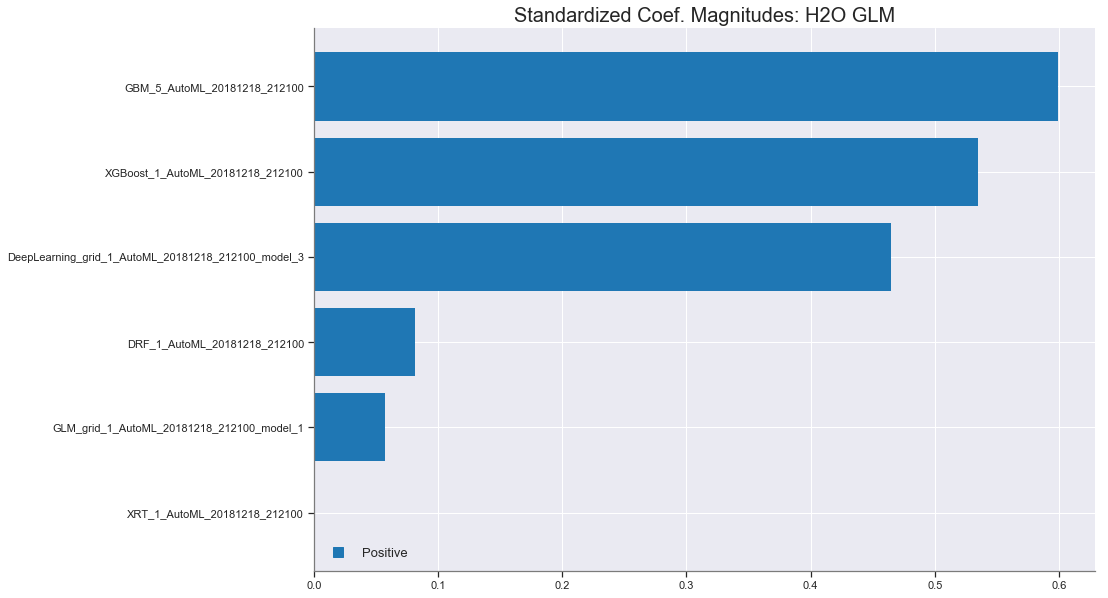

In [37]:
%matplotlib inline
metalearner.std_coef_plot()

## Conclusions and future work

<p>
    The problem presented here is very similar (if not the same) as the typical scenario of customer attrition (or churn). Where in churn we have 'customers' here we have devices, and when in churn the customer cancels the service or subscription here we have a failing device.
    <br>
    It is relatively hard to predict accurately on imbalanced data without loss of information, particularly when the ratio of data to classify with is notably skewed and when the amount of data itself is limited. Therefore, some compromises have to be taken, usually by imputing information or losing when downsampling. Moreover, the time series pose in itselft some problems to capture the idea of time within each time series.
<p>
    There are many things still to do with this dataset (and much more I guess with contextual information on the dataset features (attributes). For example,
    <ul>
        <li> With more data it would be great to test RNNs efficiently but not necessarily that should outperform other algorithms.
        <li> Trying more algorithms (AutoML from H2O is precisely a good helper on this to do automatically).
        <li> ...